In [1]:
# !pip install sciann fteikpy pyDOE -q 

In [2]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import sciann as sn 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline

---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.4 
Python Version: 3.8.16 (default, Jan 17 2023, 23:13:24) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


In [4]:
PATH_NAME = "EnDeepONet_Eikonal_Marmousi/"

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

2023-05-21 08:52:55.651924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 08:52:55.678489: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-21 08:52:55.678528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ehaghighatg4
2023-05-21 08:52:55.678534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ehaghighatg4
2023-05-21 08:52:55.678676: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 455.23.5
2023-05-21 08:52:55.678700: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported v

''

In [6]:
MARMOUSI = pd.read_csv('vel.rsf@', index_col=None, header=None)
VELMODEL = np.reshape(np.array(MARMOUSI), (2301, 751))[:, ::-1] #.T[::-1]

In [7]:
XMIN, XMAX = 0, 9.2
YMIN, YMAX = 0, 3

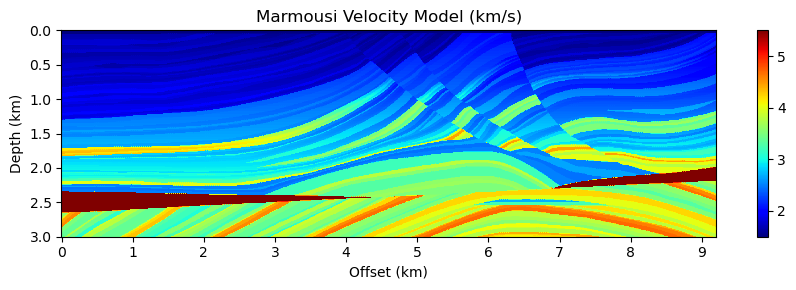

In [8]:
XGRID = np.linspace(XMIN, XMAX, 2301)
YGRID = np.linspace(YMIN, YMAX, 751)
XGRID, YGRID = np.meshgrid(XGRID, YGRID, indexing='ij')
plt.figure(figsize= (9, 3))
plt.colorbar(plt.pcolor(XGRID, YGRID, VELMODEL, cmap='jet'))
plt.yticks(np.linspace(YMIN, YMAX, 7), np.linspace(YMAX, YMIN, 7))
plt.xticks(np.linspace(0., 9., 10))
plt.title("Marmousi Velocity Model (km/s)")
plt.xlabel('Offset (km)')
plt.ylabel('Depth (km)')
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'velmodel.png'), dpi=600)
plt.show()

In [9]:
def interpolate_velocity_model(Xs, Ys, method='nearest'):
    crd = np.hstack([XGRID.reshape(-1,1), YGRID.reshape(-1,1)])
    Vs = griddata(crd, VELMODEL.flatten(), (Xs, Ys), method=method)
    return Vs.reshape(Xs.shape)

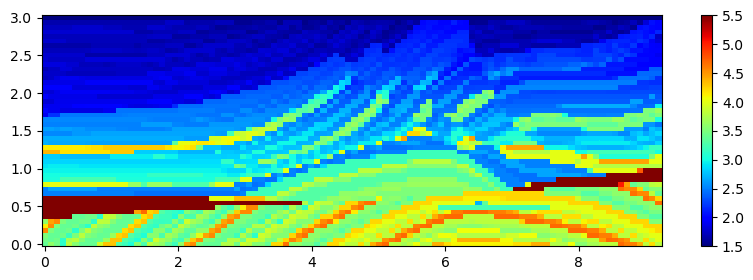

In [10]:
xt, yt = np.meshgrid(np.linspace(XMIN, XMAX, 100), np.linspace(YMIN, YMAX, 50), indexing='ij')
vt = interpolate_velocity_model(xt, yt, 'nearest')
plt.figure(figsize= (10, 3))
plt.colorbar(plt.pcolor(xt, yt, vt, cmap='jet'))
# plt.gca().invert_yaxis()
plt.show()

# Testing different velocity models 

In [11]:
import skfmm
from scipy.interpolate import griddata

class EikonalSolver:
    def __init__(self, xd = [-1.0, 1.0],
                       yd = [-1.0, 1.0],
                       vel = np.ones((10, 10)),
                       source = [0.0, 0.0]):
        self.origin = (xd[0], yd[0])
        Nx, Ny = [n - 1 for n in vel.shape]
        dx, dy = (xd[1]-xd[0])/(Nx), \
                 (yd[1]-yd[0])/(Ny)
        sx, sy = np.round((source[0] - xd[0])/dx).astype('int'), \
                 np.round((source[1] - yd[0])/dy).astype('int')
        phi = np.ones_like(vel)
        phi[sx, sy] = -1
        self.nx = (Nx+1, Ny+1)
        self.xg = np.meshgrid(np.linspace(xd[0], xd[1], Nx+1),
                              np.linspace(yd[0], yd[1], Ny+1),
                              indexing='ij')
        self.dx = (dx, dy)
        self.vg = vel
        self.Tg = skfmm.travel_time(phi,vel,dx=(dx, dy),order=2)
        
    def __call__(self, xs=0., ys=0.):
        crd = np.hstack([self.xg[0].reshape(-1,1), self.xg[1].reshape(-1,1)])
        ts = griddata(crd, self.Tg.flatten(), (xs, ys), method='nearest')
        return ts.reshape(xs.shape)
    
    @property
    def grid(self):
        return self.Tg
    
    @property
    def grad(self):
        Tx, Ty = np.gradient(self.Tg)
        return (Tx/self.dx[0], Ty/self.dx[1])
  

source =   1.6510900489246052 2.1030913237718165


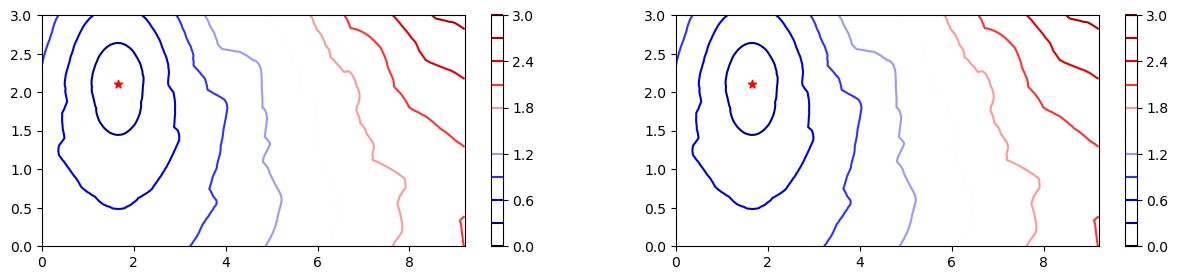

source =   3.671636235701926 2.221417992745246


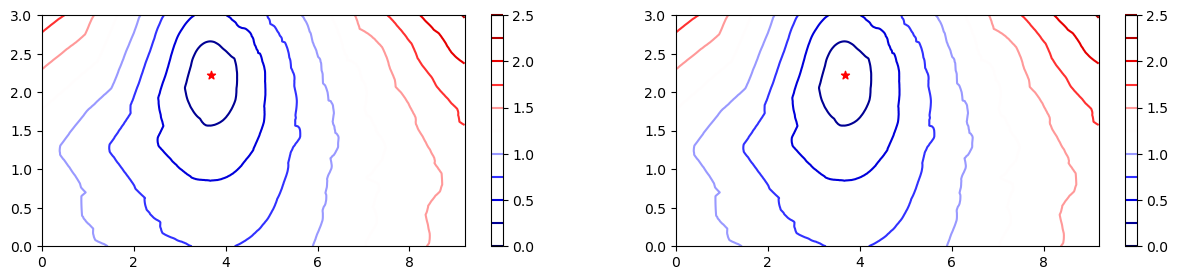

source =   8.432704633753264 2.523575374888602


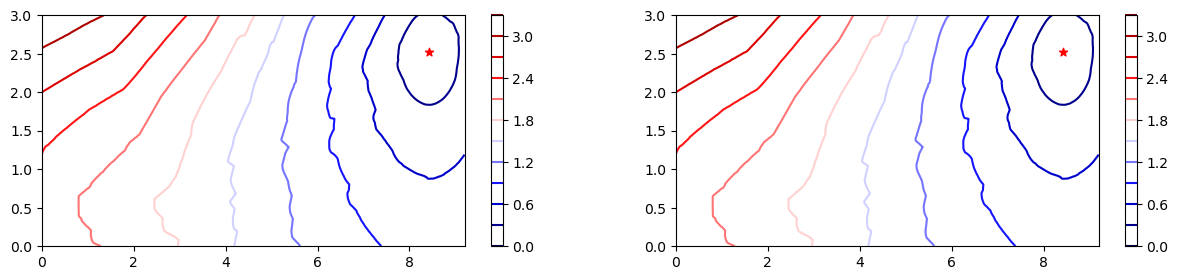

In [13]:

for i in range(3):
    xs = np.random.uniform(XMIN, XMAX)
    ys = np.random.uniform(YMIN, YMAX)
    print("source =  ", xs, ys)
    eik = EikonalSolver(xd=[XMIN, XMAX], yd=[YMIN, YMAX], vel=VELMODEL, source = [xs, ys])
    t = eik.grid
    gt = eik.grad
    res = abs(gt[0]**2 + gt[1]**2 - 1/VELMODEL**2)
    
    Nx, Ny = 300, 100
    xp, yp = np.meshgrid(np.linspace(XMIN,XMAX,Nx), np.linspace(YMIN,YMAX,Ny), indexing='ij')
    tp = eik(xp, yp)

    fig, ax = plt.subplots(1,2,figsize=(15,3))
    # plt.colorbar(
    #     ax[0].pcolor(XGRID, YGRID, VELMODEL, cmap='seismic'), ax=ax[0]
    # )
    plt.colorbar(
        ax[0].contour(XGRID, YGRID, t, 10, cmap='seismic'), ax=ax[0]
    )
    plt.colorbar(
        ax[1].contour(XGRID, YGRID, t, 10, cmap='seismic'), ax=ax[1]
    )
    # plt.colorbar(
    #     ax[2].pcolor(xgrid, ygrid, res, cmap='seismic'), ax=ax[2]
    # )
    for j in range(len(ax)):
        ax[j].scatter(xs, ys, marker='*', color='r')
    plt.show()

In [14]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [15]:
SENSOR_SIZE = 20

In [16]:
sn.reset_session()
sn.set_random_seed(1234)

# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, 
                       embedding_size=20,
                       trunk_layers=2*[50],
                       branch_layers=2*[50],
                       root_layers=7*[20],
                       actf='tanh'):
        
        # recevier (sensor) branch net
        self.branch_inputs = [sn.Variable('vb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, branch_layers, actf, actf)
        
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, actf)
        
        self.root_inputs = [self.trunk * self.branch,
                            self.trunk + self.branch,
                            self.trunk - self.branch]
        
        self.output = sn.Functional('u', self.root_inputs, root_layers, actf)
        
        du_dx = sn.diff(self.output, self.trunk_inputs[0])
        du_dy = sn.diff(self.output, self.trunk_inputs[1])
        eikonal = sn.rename(du_dx**2 + du_dy**2, 'eikonal')
        data = sn.rename(self.output*1.0, 'data')
        
        #lipschitz reg
        du_dvbranch = sn.diff(self.output, self.branch_inputs[0])
        
        self.losses = [data] #, du_dvbranch, du_dtbranch]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs,
                                 self.losses,
                                 optimizer='adam')
        
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs,
                                      self.losses,
                                      optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=4e-4,
                             final_learning_rate=1e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        learning_rate = ([0,       500, 1500, 2000,    3000,   5000, 10000], 
                         [0.5e-4, 1e-4, 1e-4, 2e-4, 0.75e-4, 0.5e-4,  1e-5])
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            reduce_lr_after=100,
            # target_weights=[1., 0.01, 0.01]
            save_weights={"path": os.path.join(PATH_NAME, "weights"), "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [17]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(data=1000, domain=1000, bc=100),
                       sensor_size = 10,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        self._sensor = [np.linspace(XMIN, XMAX, sensor_size+2)[1:-1],  np.full(sensor_size, YMAX)]
        self._shuffle = shuffle
        self._epoch = 1
        self._time = time.time()
        self._set_data()
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._sample_ids)
        print(f"epoch {self._epoch} completed in {time.time() - self._time}s ")
        self._epoch += 1

    def _set_data(self):
        num_sample, batch_size = self._sample_size, self._batch_size
        inputs, targets, sample_weights = [], [], []
        for i in range(num_sample):
            delx, dely = XMAX-XMIN, YMAX-YMIN
            x_source = np.random.uniform(XMIN + 0.1*delx, XMAX - 0.1*delx)
            y_source = np.random.uniform(YMIN + 0.1*dely, YMAX - 0.1*dely)
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(x_source, y_source, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
            if (i+1) % 10 == 0:
                print(f"sample {i+1} is generated")
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)

    def __generate_batch_data(self, x_source, y_source, batch_size):
        counter = 0
        
        # eikonal (travel-time) solution
        x_grid, y_grid = XGRID, YGRID
        eik2d = EikonalSolver(xd=[XMIN, XMAX], yd=[YMIN, YMAX], vel=VELMODEL, source=[x_source, y_source])
        
        # sample data
        ids_data = np.random.choice(x_grid.size, batch_size['data'], replace=False)
        x_data, y_data = x_grid.flatten()[ids_data], y_grid.flatten()[ids_data]
        target_data = eik2d.grid.flatten()[ids_data]
        ids_data = np.arange(batch_size['data']) + counter
        counter += ids_data.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_data]).reshape(-1,1)
        y_trunk = np.hstack([y_data]).reshape(-1,1)
        
        # - BRANCH -
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        t_sensor = eik2d(x_sensor, y_sensor)
        t_branch = np.tile(t_sensor, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, t_branch]
        targets, sample_weights = [], []
        for idx, tg in zip([ids_data],
                           [target_data]):
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            ti = np.zeros((size_sample, ))
            if isinstance(tg, np.ndarray):
                ti[idx] = tg
            targets.append(ti.reshape(-1,1))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Nx=500, Ny=200, sensor_size=10, noise=0.):
        counter = 0
        
        # eikonal solution
        eik2d = EikonalSolver(xd=[XMIN, XMAX], yd=[YMIN, YMAX], vel=VELMODEL, source=[Xs, Ys])
        
        x_grid, y_grid = np.meshgrid(np.linspace(XMIN,XMAX,Nx), np.linspace(YMIN,YMAX,Ny), indexing="ij")
        t_grid = eik2d(x_grid, y_grid)
                
        # sample domain
        x_trunk, y_trunk = x_grid.reshape(-1,1), y_grid.reshape(-1,1)
        target = t_grid.reshape(-1,1)
        size_sample = Nx*Ny
        
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        t_sensor = eik2d(x_sensor, y_sensor)
        if noise > 0.:
            t_sensor += np.random.normal(0, 1, t_sensor.shape)*(noise*np.std(t_sensor))
            t_sensor = np.maximum(0., t_sensor)

        t_branch = np.tile(t_sensor, (size_sample, 1))
        
        # inputs
        inputs = [x_trunk, y_trunk, t_branch]
        
        return inputs, t_sensor, target
    
    

In [18]:
dg = DataGenerator(
    sample_size=1,
    batch_size={'data': 10000, 'domain': 1000, 'bc':50},
    sensor_size=SENSOR_SIZE
)

In [19]:
Nx, Ny = 300, 100
x_source = np.random.uniform(XMIN, XMAX)
y_source = np.random.uniform(YMIN, YMAX)
test_data, sensor_input, target_data = dg.generate_test_data(x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
x_test = test_data[0].reshape(Nx, Ny)
y_test = test_data[1].reshape(Nx, Ny)
exact = target_data.reshape(Nx, Ny)

In [20]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    embedding_size=100,
    branch_layers=[50],
    trunk_layers=[20, 50, 100],
    root_layers=[100, 80, 60, 40, 20],
    actf='tanh'
)

In [21]:
list_weights = os.listdir(PATH_NAME)
list_weights = list(sorted(filter(lambda x: x.startswith('weights-') and not x.startswith('weights-start'), list_weights)))
list_weights[-10:]

['weights-04930-6.893e-05.hdf5',
 'weights-04940-7.920e-05.hdf5',
 'weights-04950-7.575e-05.hdf5',
 'weights-04960-7.977e-05.hdf5',
 'weights-04970-7.168e-05.hdf5',
 'weights-04980-7.362e-05.hdf5',
 'weights-04990-8.025e-05.hdf5',
 'weights-05000-7.763e-05.hdf5',
 'weights-end.hdf5',
 'weights-lbfgs.hdf5']

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-00010-5.215e-02.hdf5


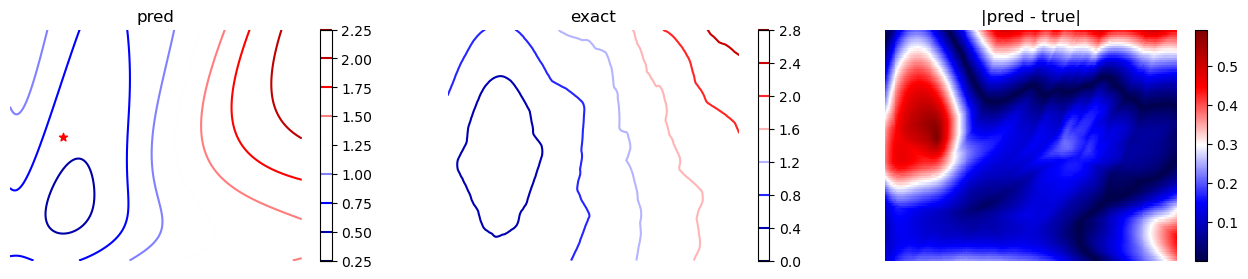

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-00510-1.435e-03.hdf5


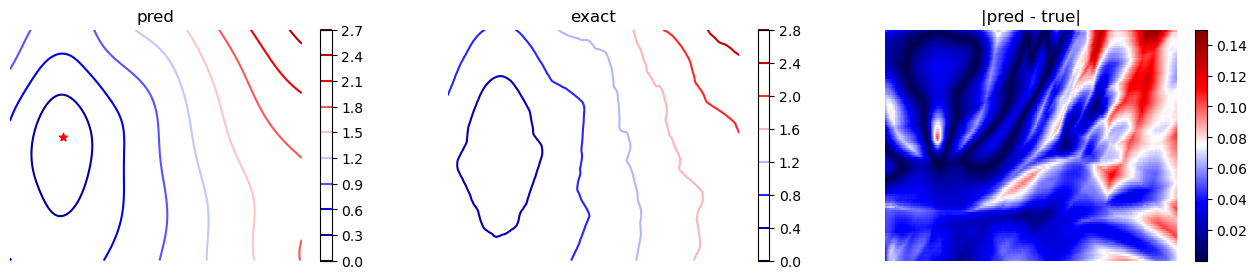

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-01010-4.651e-04.hdf5


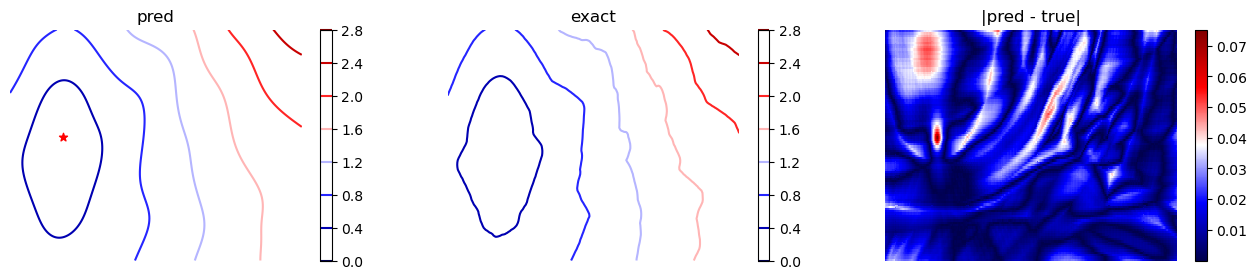

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-01510-4.349e-04.hdf5


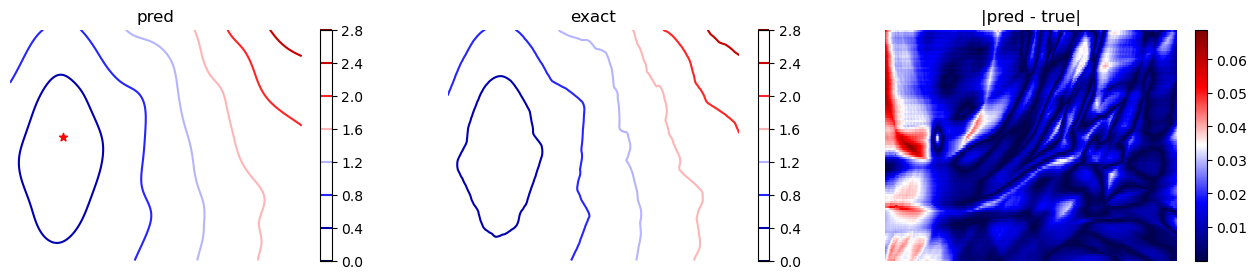

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-02010-3.518e-04.hdf5


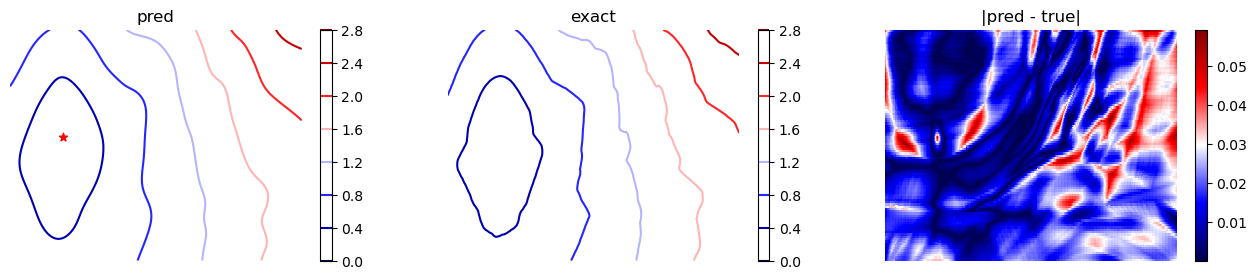

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-02510-2.195e-04.hdf5


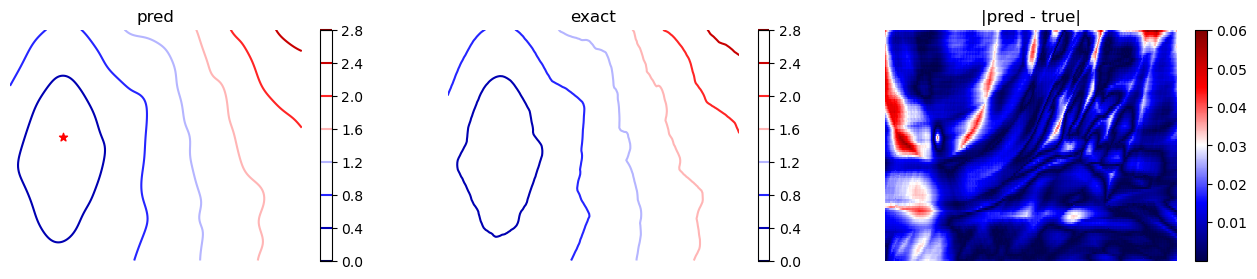

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-03010-1.435e-04.hdf5


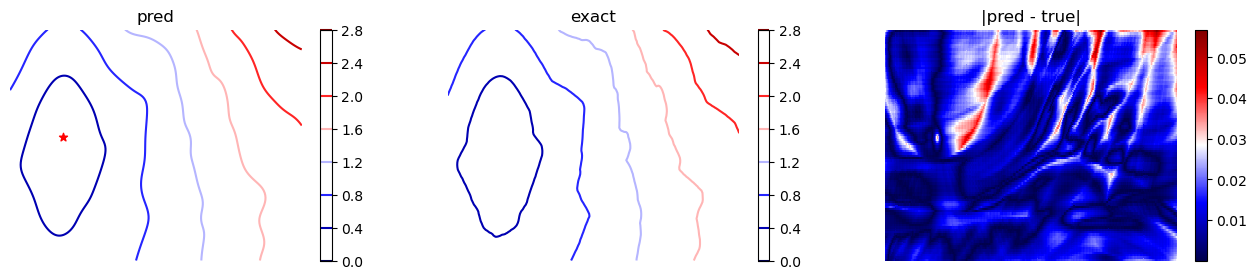

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-03510-1.052e-04.hdf5


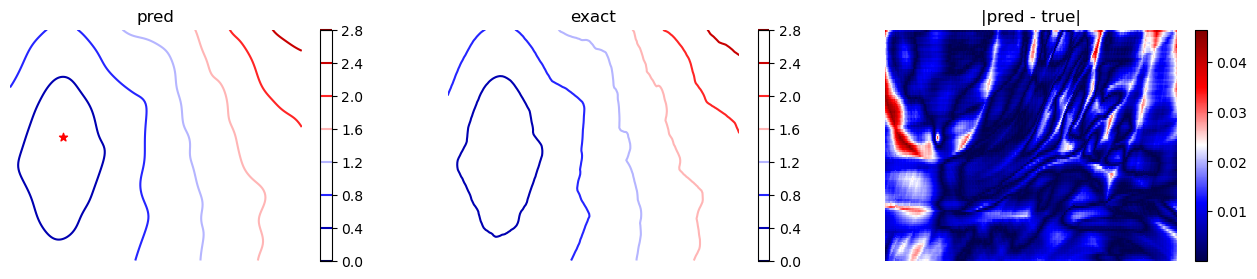

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-04010-9.739e-05.hdf5


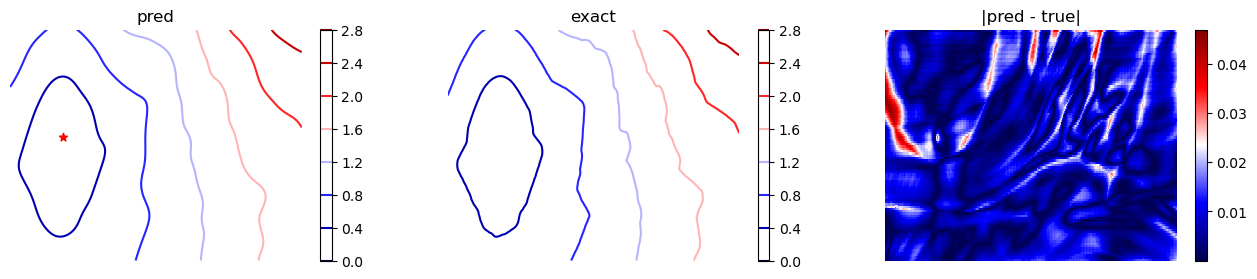

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-04510-8.665e-05.hdf5


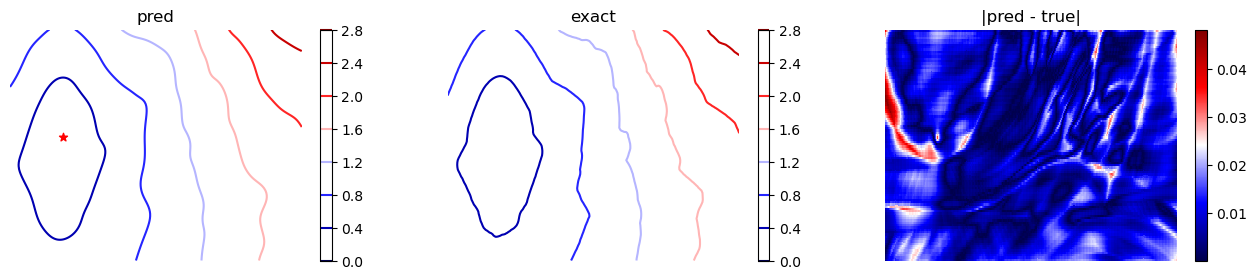

loading ...  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/weights-end.hdf5


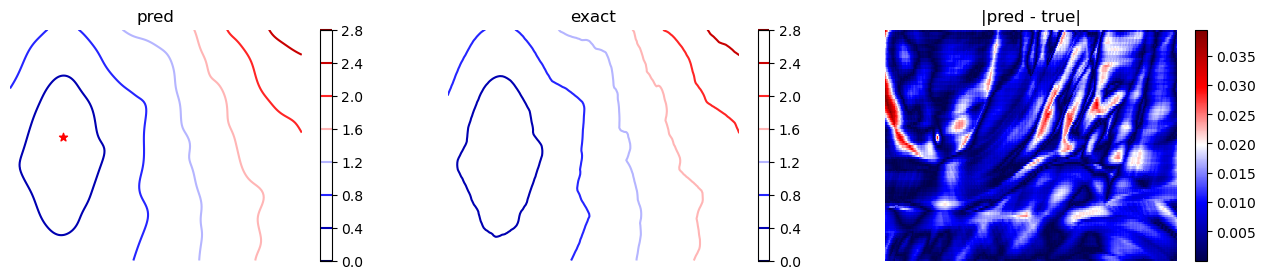

In [22]:
Nx, Ny = 300, 100
x_source = np.random.uniform(XMIN, XMAX)
y_source = np.random.uniform(YMIN, YMAX)
test_data, sensor_input, target_data = dg.generate_test_data(x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
x_test = test_data[0].reshape(Nx, Ny)
y_test = test_data[1].reshape(Nx, Ny)
exact = target_data.reshape(Nx, Ny)


for weight in list_weights[::int(len(list_weights)/10)]:
    weight_path = os.path.join(PATH_NAME, weight)
    print('loading ... ', weight_path)
    DON.model.load_weights(weight_path)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 3, figsize=(16, 3))
    
    # ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
    # ax[0].set_title('velocity field')
    # ax[0].axis('off')
    # plt.colorbar(ax0, ax=ax[0])
    ax = [None, ax[0], ax[1], ax[2]]
    ax1 = ax[1].contour(x_test, y_test, pred, cmap='seismic')
    ax[1].scatter(x_source, y_source, marker='*', color='r')
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact, cmap='seismic')
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact), cmap='seismic')
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    plt.show()

In [23]:
weight_path = os.path.join(PATH_NAME, 'weights-end.hdf5')
DON.model.load_weights(weight_path)

In [24]:
def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, title=None, cmap='jet', 
                xlabel=True, ylabel=False, vmin=None, vmax=None):
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(ax1, ax=AX)
    if Xs and Ys:
        AX.scatter(Xs, Ys, marker='*', color='r')
    AX.set_title(title)
    AX.set_yticks(np.linspace(YMIN, YMAX, 7), np.linspace(YMAX, YMIN, 7))
    if xlabel: AX.set_xlabel('Offset (km)')
    if ylabel: AX.set_ylabel('Depth (km)')

saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-pub.png


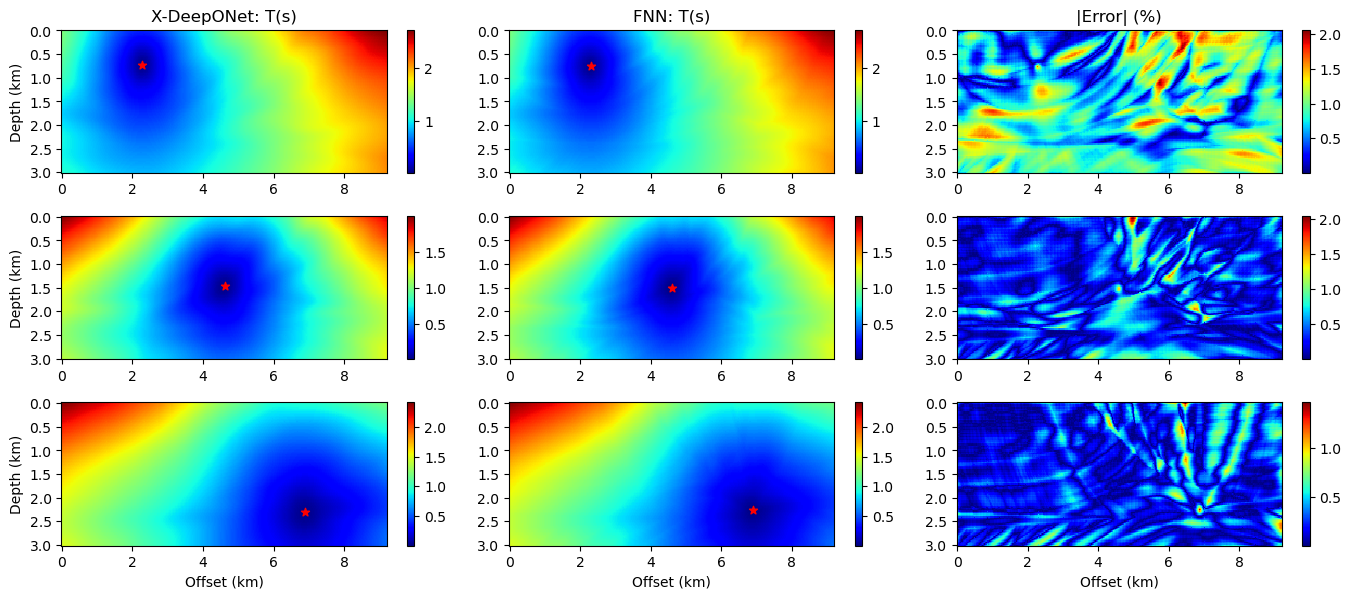

In [25]:
Nx, Ny = 300, 100

np.random.seed(652573)

delx, dely = XMAX-XMIN, YMAX-YMIN

fig, ax = plt.subplots(3, 3, figsize=(14, 6))

for i, (xi, eta) in enumerate([(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]):
    
    x_source = XMIN + xi*delx
    y_source = YMIN + eta*dely
    
    test_data, sensor_input, target_data = dg.generate_test_data(
        x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
    
    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[i_source, j_source]
    y_source_pred = y_test[i_source, j_source]

    cust_pcolor(ax[i, 0], x_test, y_test, pred, x_source_pred, y_source_pred, 'X-DeepONet: T(s)' if i==0 else None, 
                cmap='jet', vmin=exact.min(), vmax=exact.max(), ylabel=True, xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 1], x_test, y_test, exact, x_source, y_source, 'FNN: T(s)' if i==0 else None,
                'jet', xlabel=True if i==2 else False)
    
    error = abs(pred - exact) / exact.max() * 100
    cust_pcolor(ax[i, 2], x_test, y_test, error, title='|Error| (%)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)

plt.subplots_adjust(0.05, 0.08, 0.98, 0.94, 0.1, 0.3)
print("saving to: ", os.path.join(PATH_NAME, 'preds-pub.png'))
plt.savefig(os.path.join(PATH_NAME, 'preds-pub.png'))
plt.show()
#break

 trial 0 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-0.png


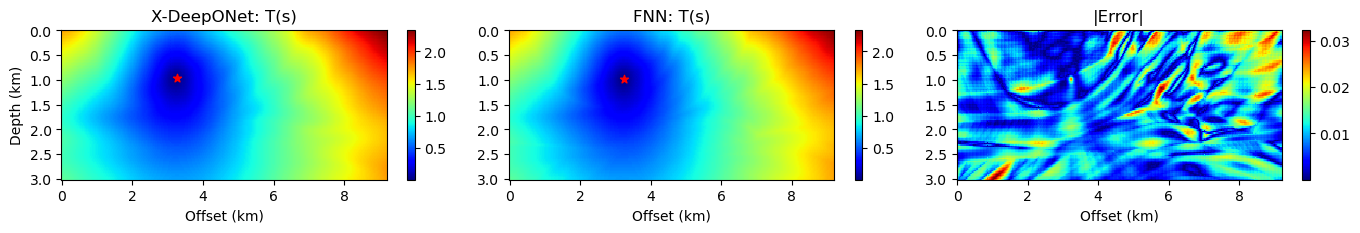

 trial 25 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-25.png


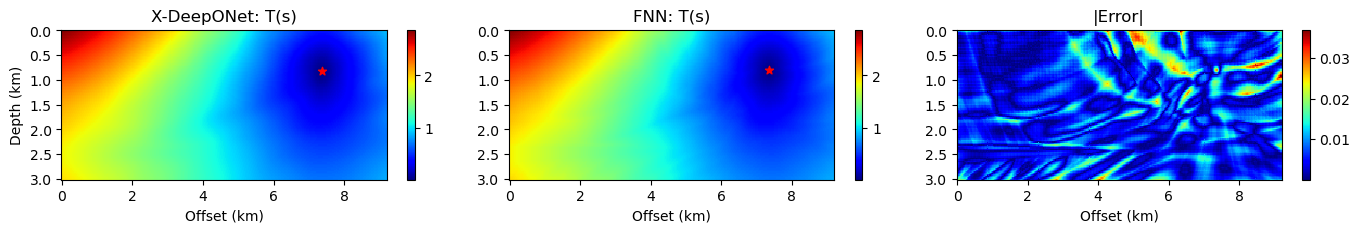

 trial 50 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-50.png


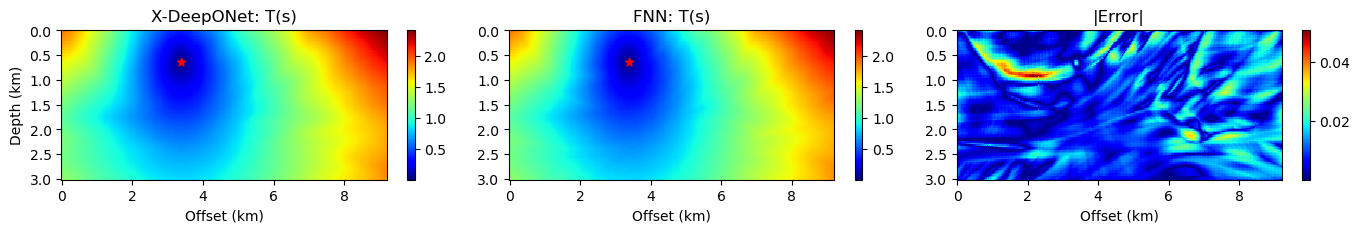

 trial 75 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-75.png


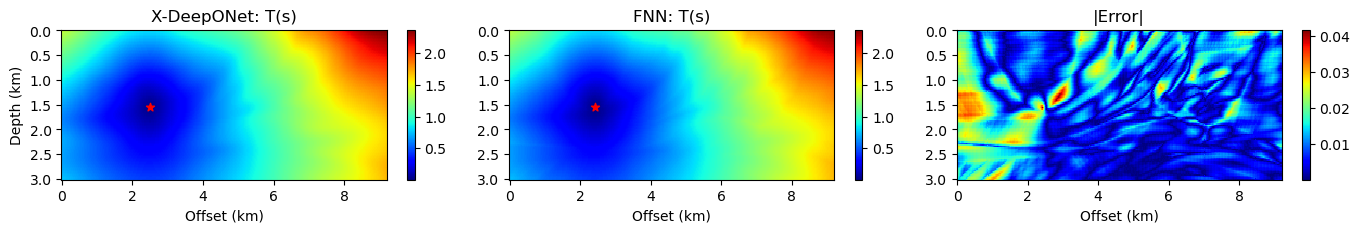

 trial 100 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-100.png


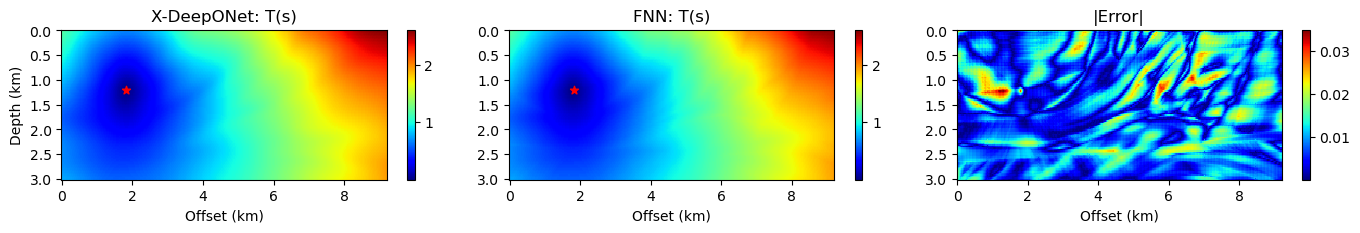

 trial 125 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-125.png


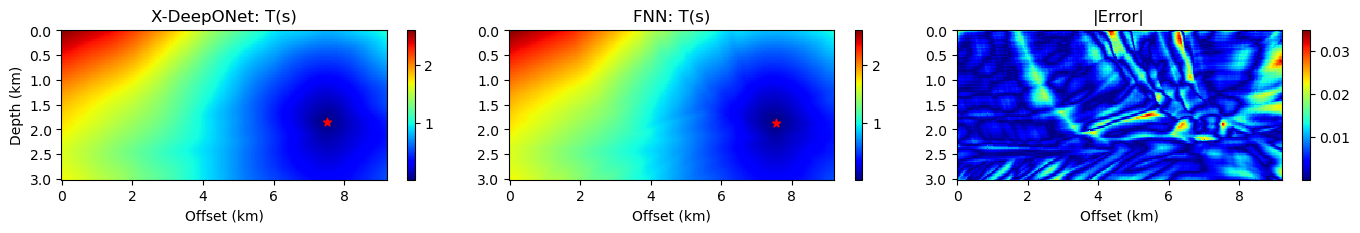

 trial 150 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-150.png


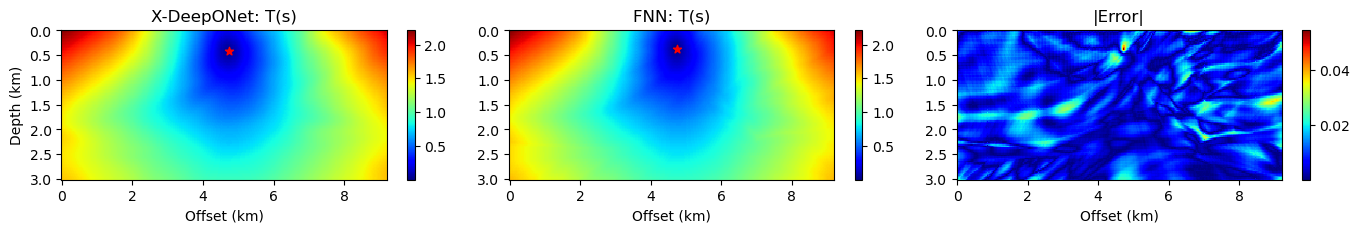

 trial 175 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-175.png


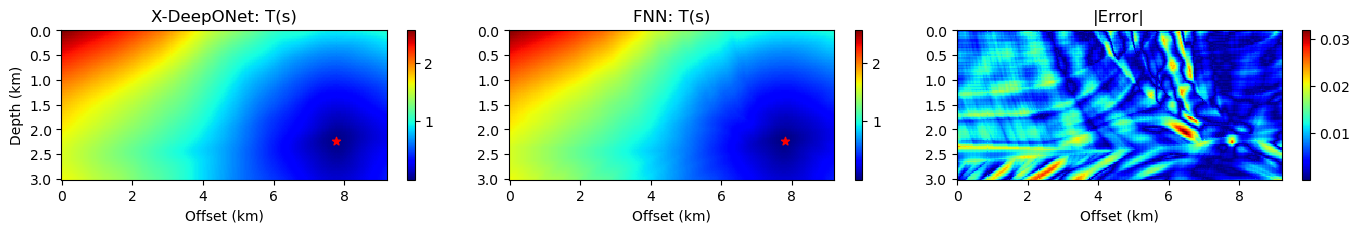

 trial 200 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-200.png


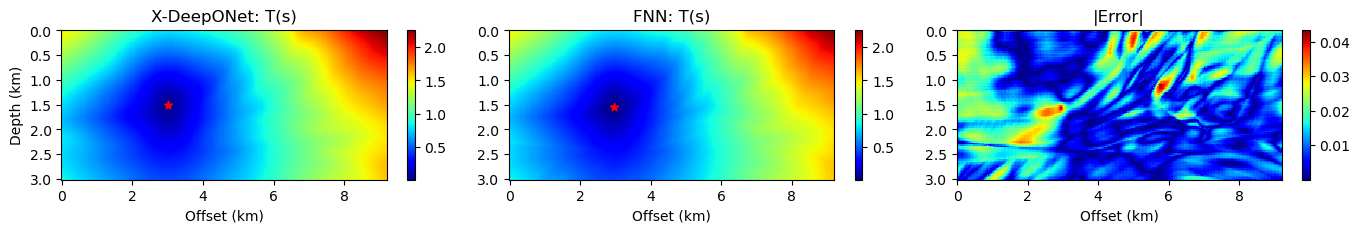

 trial 225 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-225.png


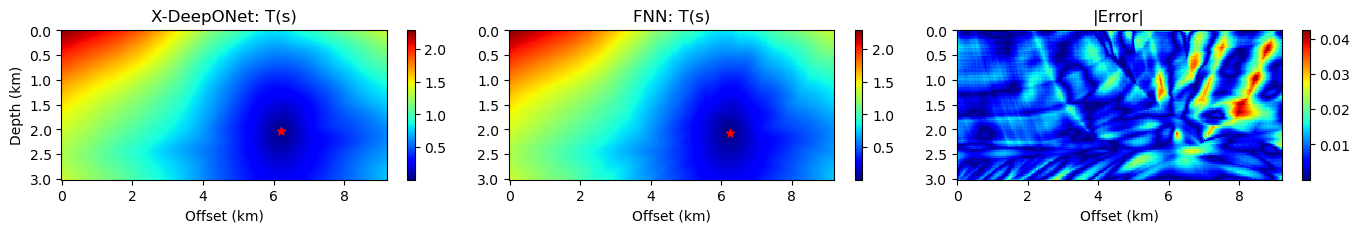

 trial 250 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-250.png


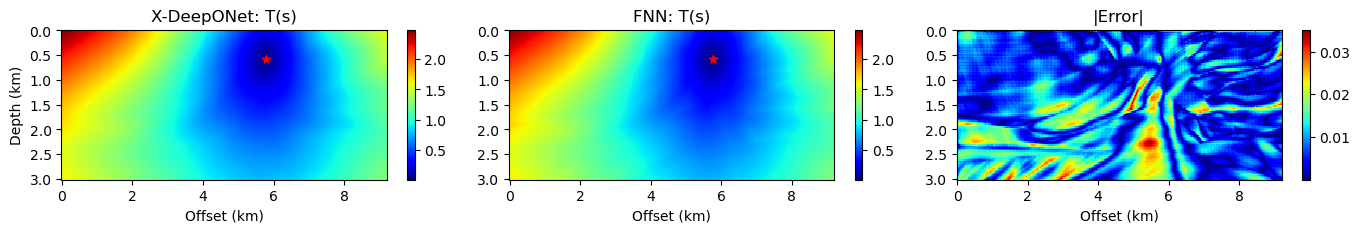

 trial 275 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-275.png


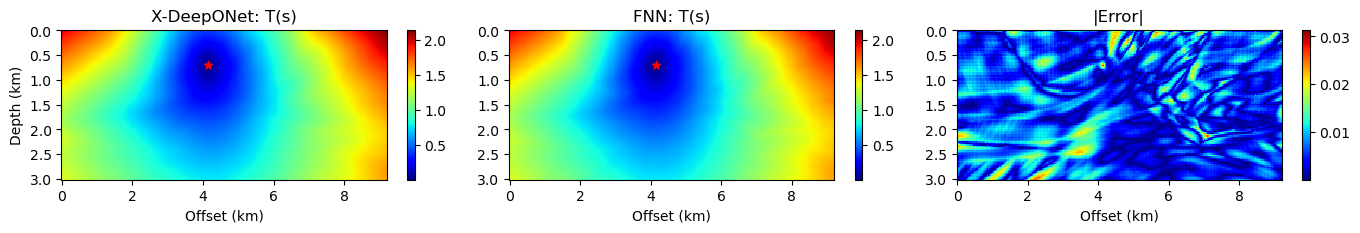

 trial 300 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-300.png


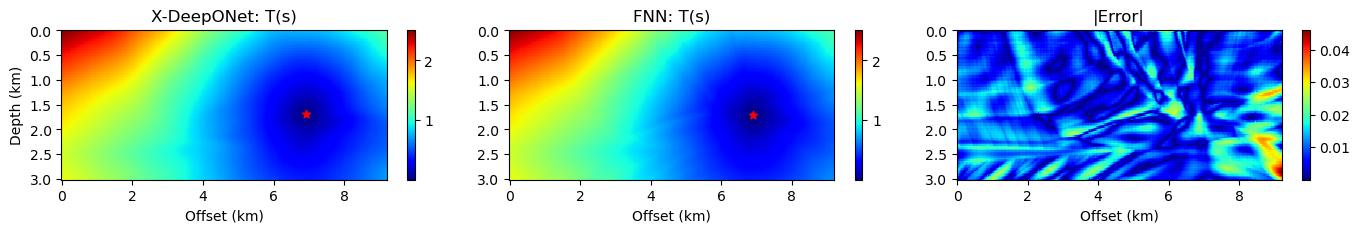

 trial 325 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-325.png


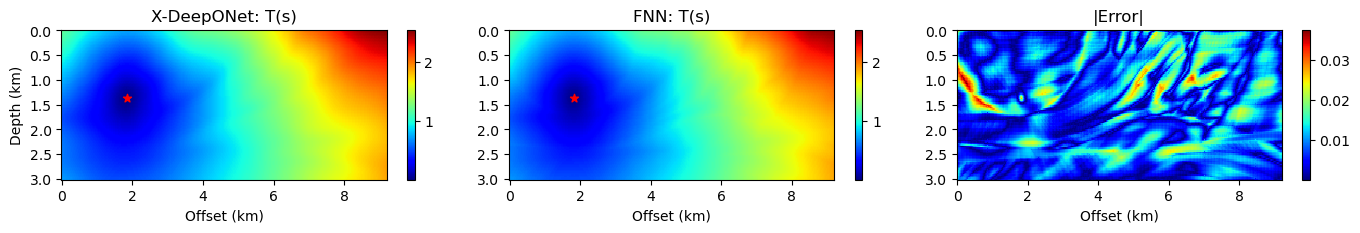

 trial 350 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-350.png


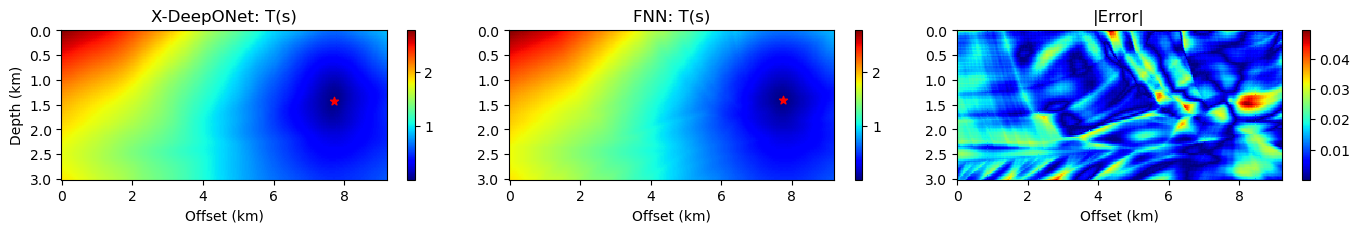

 trial 375 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-375.png


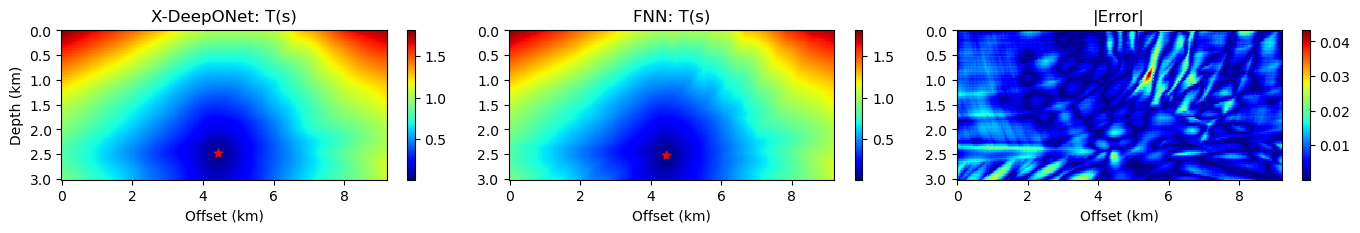

 trial 400 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-400.png


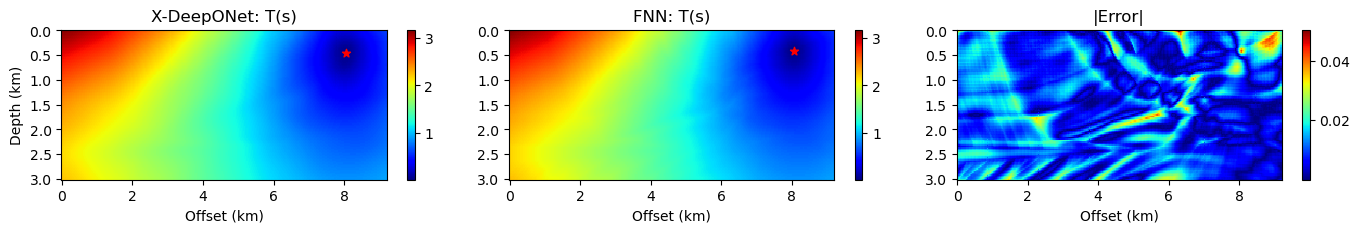

 trial 425 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-425.png


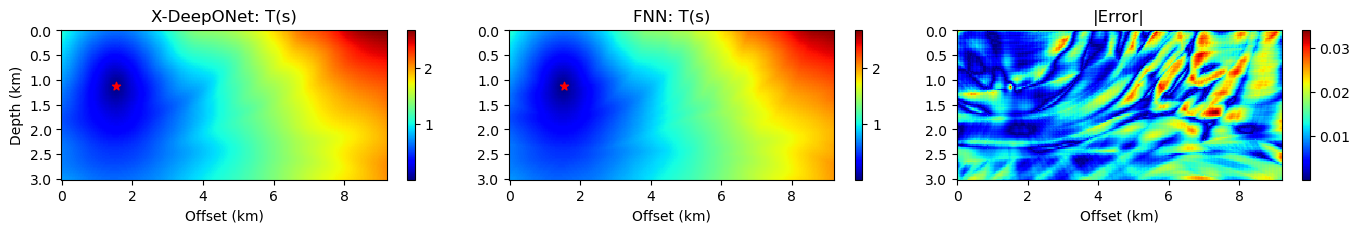

 trial 450 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-450.png


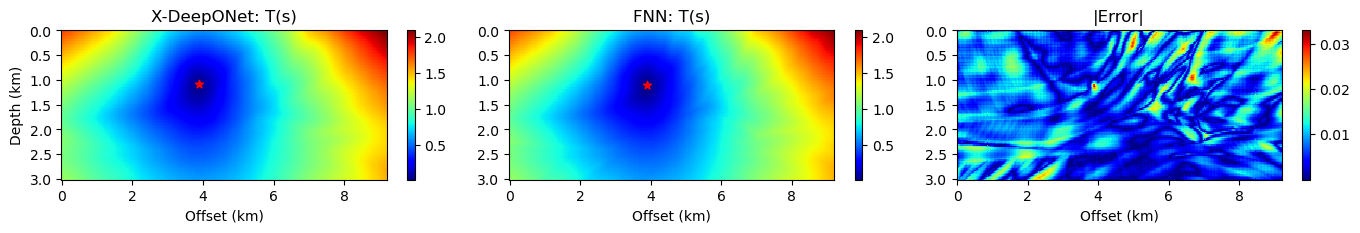

 trial 475 / 500
saving to:  PI_DeepXXXnet_Eikonal_Marmousi_source_identification_sciann_datadriven/preds-475.png


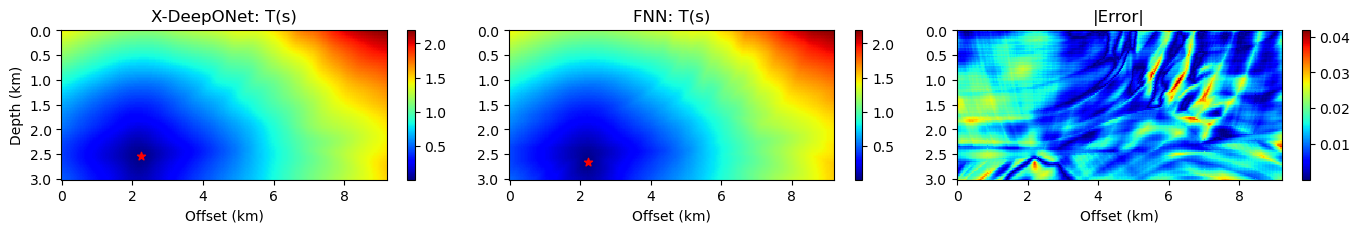

In [26]:
Nx, Ny = 300, 100

rmse_error = []
source_loc = []
source_error = []

np.random.seed(652573)

NUM_TRIAL = 500
for i in range(NUM_TRIAL):
    
    delx, dely = XMAX-XMIN, YMAX-YMIN
    x_source = np.random.uniform(XMIN + 0.1*delx, XMAX - 0.1*delx)
    y_source = np.random.uniform(YMIN + 0.1*dely, YMAX - 0.1*dely)
    
    test_data, sensor_input, target_data = dg.generate_test_data(
        x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
    
    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[i_source, j_source]
    y_source_pred = y_test[i_source, j_source]
    
    rmse_error.append(
        np.sqrt(np.mean(exact - pred)**2)
    )
    source_loc.append(
        [x_source, y_source]
    )
    source_error.append(
        [x_source-x_source_pred, y_source-y_source_pred]
    )

    if i % int(NUM_TRIAL/20) == 0:
        print(f' trial {i} / {NUM_TRIAL}')
        fig, ax = plt.subplots(1, 3, figsize=(14, 2.5))
        # ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
        # ax[0].set_title('velocity field')
        # ax[0].axis('off')
        # plt.colorbar(ax0, ax=ax[0])
        ax = [None, ax[0], ax[1], ax[2]]
        cust_pcolor(ax[1], x_test, y_test, pred, x_source_pred, y_source_pred, 'X-DeepONet: T(s)', 'jet',
                    vmin=exact.min(), vmax=exact.max(), ylabel=True)
        cust_pcolor(ax[2], x_test, y_test, exact, x_source, y_source, 'FNN: T(s)', 'jet')
        cust_pcolor(ax[3], x_test, y_test, abs(pred - exact), title='|Error|', cmap='jet')
        plt.subplots_adjust(0.05, 0.2, 0.98, 0.8, 0.1, 0.1)
        print("saving to: ", os.path.join(PATH_NAME, f'preds-{i}.png'))
        plt.savefig(os.path.join(PATH_NAME, f'preds-{i}.png'))
        plt.show()
        #break

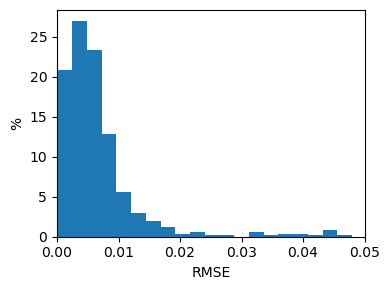

In [27]:
rmse_error = np.array(rmse_error)
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
plt.figure(figsize=(4,3))
plt.hist(rmse_error, 20, weights=weights)
plt.xlabel('RMSE')
plt.ylabel('%')
plt.xlim(0., 0.05)
plt.tight_layout()
plt.savefig(
    os.path.join(PATH_NAME, 'ekional_source_error_distribution.pdf')
)

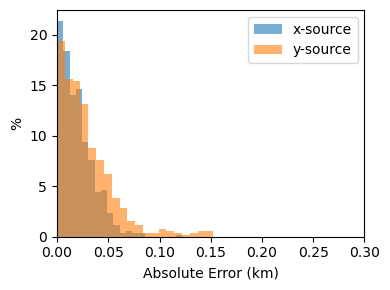

In [28]:
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
source_error = np.array(source_error)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = [ax]
ax[0].hist(abs(source_error[:, 0]), 20, weights=weights, alpha=0.6, label='x-source')
ax[0].hist(abs(source_error[:, 1]), 20, weights=weights, alpha=0.6, label='y-source')
# ax[0].set_xlabel('x-source')
# ax[0].set_xlabel('y-source')
ax[0].set_xlabel('Absolute Error (km)')
ax[0].set_ylabel('%')
# ax[1].set_ylabel('%')
ax[0].set_xlim(0., 0.3)
plt.tight_layout()
plt.legend()
plt.savefig(
    os.path.join(PATH_NAME, 'ekional_XY-source_error_distribution.pdf')
)

In [30]:
Nx, Ny = 300, 100
NUM_TRIAL = 500

noise_vals =  [0.01, 0.1, 0.2, 0.5]
noise_error = []
noise_source_error = []

for noise in noise_vals:
    rmse_error2 = []
    source_loc2 = []
    source_error2 = []

    for i in range(NUM_TRIAL):

        x_source = np.random.uniform(XMIN, XMAX)
        y_source = np.random.uniform(YMIN, YMAX)

        test_data, sensor_input, target_data = dg.generate_test_data(
            x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=noise)

        x_test = test_data[0].reshape(Nx, Ny)
        y_test = test_data[1].reshape(Nx, Ny)
        exact = target_data.reshape(Nx, Ny)

        pred = DON.eval_u(test_data).reshape(Nx, Ny)
        
        i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
        x_source_pred = x_test[i_source, j_source]
        y_source_pred = y_test[i_source, j_source]

        rmse_error2.append(
            np.sqrt(np.mean(exact - pred)**2)
        )
        source_loc2.append(
            [x_source, y_source]
        )
        source_error2.append(
            [x_source-x_source_pred, y_source-y_source_pred]
        )
    print(f'done with noise = {noise}')
    noise_error.append(rmse_error2)
    noise_source_error.append(source_error2)

done with noise = 0.01
done with noise = 0.1
done with noise = 0.2
done with noise = 0.5


In [31]:
noise_source_error = np.array(noise_source_error)
noise_error = np.array(noise_error)
noise_Xsource_error = noise_source_error[:,:,0]
noise_Ysource_error = noise_source_error[:,:,1]

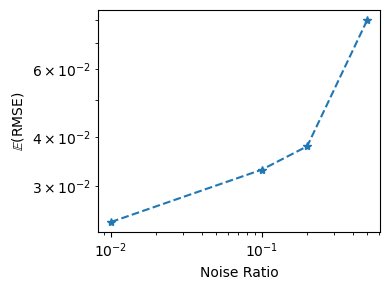

In [32]:
plt.figure(figsize=(4,3))
plt.loglog(noise_vals, np.mean(noise_error, axis=-1), '--*')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$(RMSE)')
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'ekional_source_noise_sensitivity.pdf'))

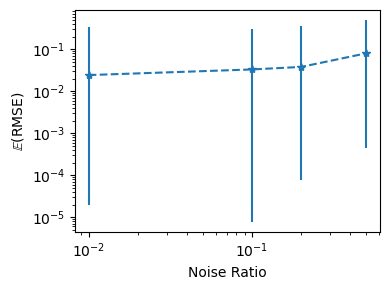

In [33]:
plt.figure(figsize=(4,3))
yerr_min = np.mean(noise_error, axis=-1) - np.min(noise_error, axis=-1)
yerr_max = np.max(noise_error, axis=-1) - np.mean(noise_error, axis=-1)
plt.errorbar(noise_vals, np.mean(noise_error, axis=-1), 
             yerr=[yerr_min, yerr_max], 
             linestyle='--', marker='*')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$(RMSE)')
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(PATH_NAME, 'ekional_source_noise_sensitivity.pdf'))

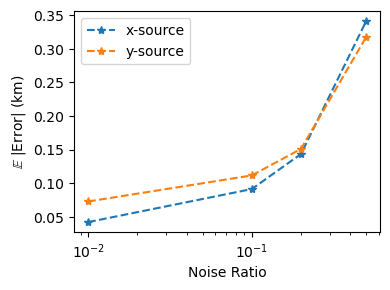

In [34]:
plt.figure(figsize=(4,3))
plt.semilogx(noise_vals, abs(noise_Xsource_error).mean(axis=-1), '--*', label='x-source')
plt.semilogx(noise_vals, abs(noise_Ysource_error).mean(axis=-1), '--*', label='y-source')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$ |Error| (km)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'ekional_XY-source_noise_sensitivity.pdf'))

In [ ]:
y_test.min(), y_test.max()

(0.0, 3.0)

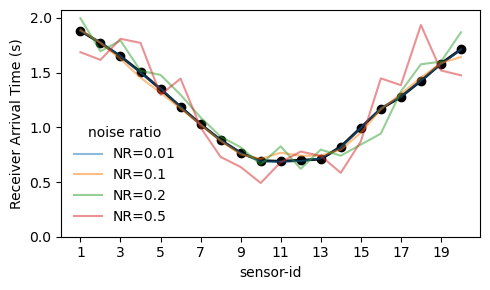

In [35]:
Nx, Ny = 100, 100
np.random.seed(6354)

fig = plt.figure(figsize=(5, 3))

sensor_id = np.arange(1, 21, 1)
x_source = (XMIN + XMAX)/2
y_source = (YMIN + YMAX)/2

test_data, sensor_input, target_data = dg.generate_test_data(
    x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=0.)

plt.plot(sensor_id, test_data[2][0, :], '-ok', lw=2, ms=6)

for noise in [0.01, 0.1, 0.2, 0.5]:
    for i in range(1):
        test_data, sensor_input, target_data = dg.generate_test_data(
            x_source, y_source, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=noise)

        plt.plot(sensor_id, test_data[2][0, :], '-', label=f'NR={noise}', alpha=0.5)
        

plt.ylim(0, None)
plt.ylabel('Receiver Arrival Time (s)')
plt.xlabel('sensor-id')
plt.xticks(np.arange(1, 21, 2))
plt.tight_layout()
plt.legend(title="noise ratio", loc='lower left', frameon=False)
plt.savefig(os.path.join(PATH_NAME, 'recevier-noise-realizations.pdf'))